## Word Embeddings con Word2Vec

- Entrenar modelos Word2Vec con CBOW y Skip-Gram
- Buscar palabras similares
- Visualizar embeddings en 2D usando t-SNE y PCA
- Mostrar noticias de diferentes tópicos en el espacio de embeddings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv(
    "noticias_unificadas.tsv",
    encoding="utf-8",
    sep="\t",
    dtype={"fecha": "string", "titulo": "string", "contenido": "string", "seccion": "string", "link": "string"},
    quoting=0,
    na_filter=False
)

print(f"Total de documentos: {len(df)}")
print(f"\nCategorías: {df['seccion'].nunique()}")
print(df['seccion'].value_counts())

Total de documentos: 37746

Categorías: 7
seccion
Política        12509
Espectáculos     6386
Mundo            5186
Deportes         4739
Cultura          3256
Economía         3168
Policiales       2502
Name: count, dtype: Int64


In [3]:
from utils.utils import clean_text

df["headline_text"] = (df["titulo"].fillna("") + " " + df["contenido"].fillna(""))


In [4]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import gensim

# Stopwords en español
STOPWORDS = set(stopwords.words("spanish"))

STOP_EXTRA = {
    "dijo", "anos", "foto", "video", "puedes", "ver", "hoy", "ayer", "manana", 
    "mas", "recomendado", "ser", "dia", "dias", "tambien", "cada", "tras", 
    "soles", "uno", "dos", "tres", "asi", "mil", "ano", "año", "solo", 
    "senalo", "segun", "entre", "millones", "lugar", "puede", "haber", 
    "tener", "sol", "precio", "yape", "pai", "nueva", "hace", "hacer"
}

STOPWORDS |= STOP_EXTRA

print(f"Total de stopwords: {len(STOPWORDS)}")

Total de stopwords: 352


In [5]:

def preprocess_for_w2v(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 3:
            result.append(token)
    return result


ejemplo = "El presidente anunció nuevas elecciones políticas en el congreso"
print("Texto original:")
print(ejemplo)
print("\nTokens procesados:")
print(preprocess_for_w2v(ejemplo))

Texto original:
El presidente anunció nuevas elecciones políticas en el congreso

Tokens procesados:
['presidente', 'anunció', 'nuevas', 'elecciones', 'políticas', 'congreso']


In [6]:

print("Procesando documentos para Word2Vec...")
processed_docs = df['headline_text'].map(preprocess_for_w2v)

sentences = processed_docs.tolist()

print(f"\nTotal de documentos procesados: {len(sentences)}")
print(f"\nEjemplo de documento procesado:")
print(sentences[100][:20])

doc_lengths = [len(doc) for doc in sentences]
print(f"\nEstadísticas de longitud:")
print(f"  Media: {np.mean(doc_lengths):.2f} tokens")
print(f"  Mediana: {np.median(doc_lengths):.2f} tokens")
print(f"  Min: {min(doc_lengths)}, Max: {max(doc_lengths)}")

Procesando documentos para Word2Vec...

Total de documentos procesados: 37746

Ejemplo de documento procesado:
['diego', 'leon', 'director', 'cine', 'siempre', 'quisimos', 'contar', 'hazana', 'militar', 'entrevista', 'diego', 'leon', 'toma', 'calma', 'exito', 'polemica', 'generado', 'primera', 'semana', 'exhibicion']

Estadísticas de longitud:
  Media: 195.71 tokens
  Mediana: 166.00 tokens
  Min: 13, Max: 6543


## Entrenar Modelo Word2Vec

### CBOW (Continuous Bag of Words)
- Predice la palabra central dado el contexto
- Más rápido de entrenar
- Mejor para palabras frecuentes

### Skip-Gram
- Predice el contexto dada la palabra central
- Más lento de entrenar
- Mejor para palabras poco frecuentes

In [7]:
print("ENTRENANDO WORD2VEC CON CBOW")

vector_size = 100
window = 5
min_count = 5
workers = 4
epochs = 20

# Entrenar CBOW (sg=0)
model_cbow = Word2Vec(
    sentences=sentences,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=workers,
    epochs=epochs,
    sg=0,
    seed=42
)

print(f"\nModelo CBOW entrenado exitosamente")
print(f"Vocabulario: {len(model_cbow.wv)} palabras")

ENTRENANDO WORD2VEC CON CBOW

Modelo CBOW entrenado exitosamente
Vocabulario: 54340 palabras


In [8]:
print("ENTRENANDO WORD2VEC CON SKIP-GRAM")

# Entrenar Skip-Gram (sg=1)
model_skipgram = Word2Vec(
    sentences=sentences,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=workers,
    epochs=epochs,
    sg=1,
    seed=42
)

print(f"\nModelo Skip-Gram entrenado exitosamente")
print(f"Vocabulario: {len(model_skipgram.wv)} palabras")

ENTRENANDO WORD2VEC CON SKIP-GRAM

Modelo Skip-Gram entrenado exitosamente
Vocabulario: 54340 palabras


### Buscar Palabras Similares

In [25]:
def find_similar_words(model, word, topn=10):
    try:
        similar = model.wv.most_similar(word, topn=topn)
        return similar
    except KeyError:
        return None

def compare_models_similarity(word, model_cbow, model_skipgram, topn=10):
    print(f"PALABRAS SIMILARES A: '{word}'")

    # CBOW
    print(f"\nModelo CBOW:")
    similar_cbow = find_similar_words(model_cbow, word, topn)
    if similar_cbow:
        for i, (w, score) in enumerate(similar_cbow, 1):
            print(f"  {i:2}. {w:20s} → similitud: {score:.4f}")
    else:
        print(f" Palabra '{word}' no encontrada en vocabulario CBOW")
    
    # Skip-Gram
    print(f"\nModelo Skip-Gram:")
    similar_sg = find_similar_words(model_skipgram, word, topn)
    if similar_sg:
        for i, (w, score) in enumerate(similar_sg, 1):
            print(f"  {i:2}. {w:20s} → similitud: {score:.4f}")
    else:
        print(f"Palabra '{word}' no encontrada en vocabulario Skip-Gram")

In [26]:
compare_models_similarity("elecciones", model_cbow, model_skipgram, topn=10)

PALABRAS SIMILARES A: 'elecciones'

Modelo CBOW:
   1. comicios             → similitud: 0.8286
   2. electoral            → similitud: 0.6523
   3. electorales          → similitud: 0.6102
   4. precandidaturas      → similitud: 0.5931
   5. candidaturas         → similitud: 0.5703
   6. congregaciones       → similitud: 0.5688
   7. candidatos           → similitud: 0.5549
   8. presidenciales       → similitud: 0.5464
   9. planchas             → similitud: 0.5360
  10. eleccion             → similitud: 0.5255

Modelo Skip-Gram:
   1. comicios             → similitud: 0.8725
   2. presidenciales       → similitud: 0.8233
   3. electoral            → similitud: 0.8026
   4. generales            → similitud: 0.7969
   5. primarias            → similitud: 0.7489
   6. electorales          → similitud: 0.7307
   7. candidatos           → similitud: 0.6996
   8. precandidaturas      → similitud: 0.6992
   9. inscriban            → similitud: 0.6978
  10. escrutadas           → similitud:

In [27]:
compare_models_similarity("chancay", model_cbow, model_skipgram, topn=10)

PALABRAS SIMILARES A: 'chancay'

Modelo CBOW:
   1. megapuerto           → similitud: 0.7053
   2. corio                → similitud: 0.6877
   3. matarani             → similitud: 0.6690
   4. puerto               → similitud: 0.5694
   5. muelle               → similitud: 0.5579
   6. puertos              → similitud: 0.5481
   7. cabotaje             → similitud: 0.5341
   8. siguas               → similitud: 0.5274
   9. portuario            → similitud: 0.5129
  10. megaproyecto         → similitud: 0.5087

Modelo Skip-Gram:
   1. megapuerto           → similitud: 0.7757
   2. puerto               → similitud: 0.6787
   3. corio                → similitud: 0.6740
   4. cabotaje             → similitud: 0.6565
   5. multiproposito       → similitud: 0.6373
   6. navieras             → similitud: 0.6284
   7. conectaria           → similitud: 0.6244
   8. megaproyecto         → similitud: 0.6220
   9. portuario            → similitud: 0.6201
  10. inapari              → similitud: 0.

In [28]:
for word in ["delincuencia", "delmcuencia", "delito", "crimen"]:
    if word in model_cbow.wv:
        print(f"\nPalabra encontrada: '{word}'")
        compare_models_similarity(word, model_cbow, model_skipgram, topn=8)
        break


Palabra encontrada: 'delincuencia'
PALABRAS SIMILARES A: 'delincuencia'

Modelo CBOW:
   1. criminalidad         → similitud: 0.9054
   2. flagelo              → similitud: 0.7670
   3. inseguridad          → similitud: 0.7280
   4. extorsiones          → similitud: 0.6441
   5. crimen               → similitud: 0.5969
   6. extorsion            → similitud: 0.5934
   7. sicariato            → similitud: 0.5845
   8. problematica         → similitud: 0.5530

Modelo Skip-Gram:
   1. criminalidad         → similitud: 0.8589
   2. inseguridad          → similitud: 0.7921
   3. ciudadana            → similitud: 0.7183
   4. combatir             → similitud: 0.7139
   5. flagelo              → similitud: 0.7135
   6. crimen               → similitud: 0.6988
   7. coadyuven            → similitud: 0.6880
   8. sicariato            → similitud: 0.6849


In [29]:
palabras_test = ["presidente", "gobierno", "equipo", "partido", "economia", "dolar"]

for palabra in palabras_test:
    if palabra in model_cbow.wv:
        compare_models_similarity(palabra, model_cbow, model_skipgram, topn=8)
        print("\n")

PALABRAS SIMILARES A: 'presidente'

Modelo CBOW:
   1. expresidente         → similitud: 0.7001
   2. mandatario           → similitud: 0.6967
   3. presidencia          → similitud: 0.6311
   4. vicepresidente       → similitud: 0.6127
   5. presidenta           → similitud: 0.6053
   6. jefe                 → similitud: 0.5747
   7. homologo             → similitud: 0.5507
   8. titular              → similitud: 0.5506

Modelo Skip-Gram:
   1. vicepresidente       → similitud: 0.7066
   2. electo               → similitud: 0.7021
   3. mandatario           → similitud: 0.6908
   4. presiente            → similitud: 0.6447
   5. homologo             → similitud: 0.6268
   6. dimite               → similitud: 0.6225
   7. alckmin              → similitud: 0.6212
   8. mondino              → similitud: 0.6207


PALABRAS SIMILARES A: 'gobierno'

Modelo CBOW:
   1. ejecutivo            → similitud: 0.5855
   2. mandatario           → similitud: 0.5584
   3. carondelet           → similitu

### Visualización de Embeddings

In [30]:

def visualize_embeddings_tsne(model, words, title="Word Embeddings (t-SNE)", perplexity=30):

    valid_words = [w for w in words if w in model.wv]
    vectors = np.array([model.wv[w] for w in valid_words])
    
    perplexity = min(perplexity, len(valid_words) - 1)
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    vectors_2d = tsne.fit_transform(vectors)

    plt.figure(figsize=(14, 10))
    plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], alpha=0.6, s=100, color='steelblue')

    for i, word in enumerate(valid_words):
        plt.annotate(word, xy=(vectors_2d[i, 0], vectors_2d[i, 1]),
                    xytext=(5, 2), textcoords='offset points',
                    fontsize=9, alpha=0.8)
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Dimensión 1', fontsize=12)
    plt.ylabel('Dimensión 2', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [31]:
palabras_topicos = {
    "Política": ["presidente", "congreso", "gobierno", "ministro", "elecciones", "politico", "partido"],
    "Deportes": ["equipo", "partido", "jugador", "futbol", "entrenador", "campeonato", "goles"],
    "Economía": ["economia", "dolar", "empresa", "mercado", "banco", "financiero", "comercio"],
    "Policiales": ["policia", "delito", "seguridad", "crimen", "detenido", "investigacion"],
    "Cultura": ["cultura", "arte", "museo", "teatro", "literatura", "musica", "exposicion"],
    "Espectáculos": ["cine", "musica", "festival", "artista", "concierto", "pelicula", "evento"],
    "Mundo": ["internacional", "naciones", "conflicto", "pais", "guerra", "diplomatico", "relaciones"]
}

todas_palabras = []
for topico, palabras in palabras_topicos.items():
    todas_palabras.extend(palabras)

print(f"Total de palabras seleccionadas: {len(todas_palabras)}")
print(f"Palabras: {todas_palabras}")

Total de palabras seleccionadas: 48
Palabras: ['presidente', 'congreso', 'gobierno', 'ministro', 'elecciones', 'politico', 'partido', 'equipo', 'partido', 'jugador', 'futbol', 'entrenador', 'campeonato', 'goles', 'economia', 'dolar', 'empresa', 'mercado', 'banco', 'financiero', 'comercio', 'policia', 'delito', 'seguridad', 'crimen', 'detenido', 'investigacion', 'cultura', 'arte', 'museo', 'teatro', 'literatura', 'musica', 'exposicion', 'cine', 'musica', 'festival', 'artista', 'concierto', 'pelicula', 'evento', 'internacional', 'naciones', 'conflicto', 'pais', 'guerra', 'diplomatico', 'relaciones']


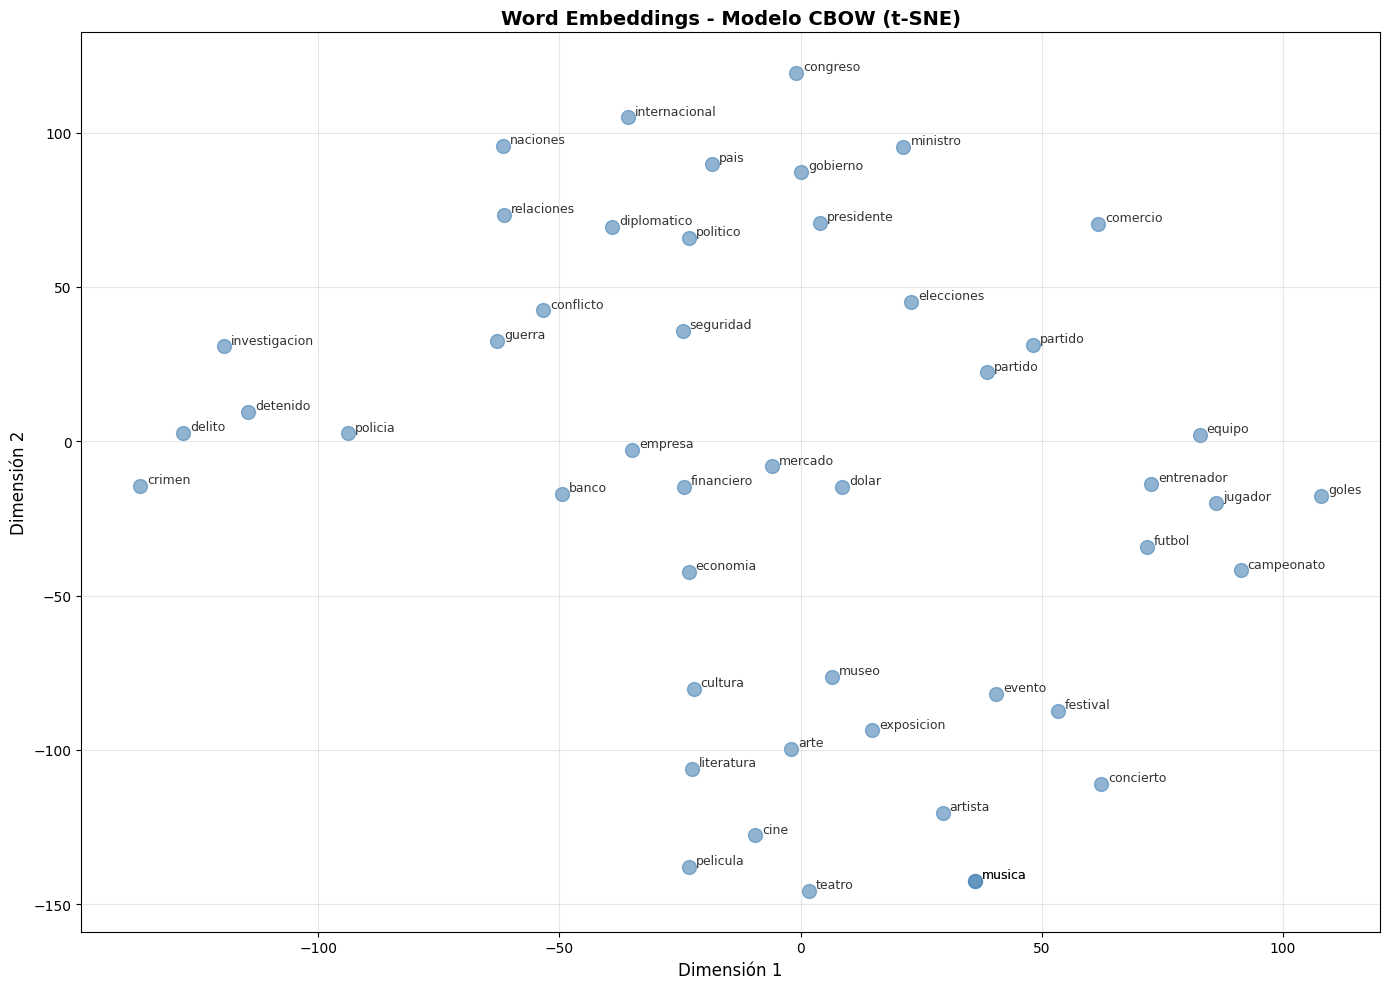

In [16]:
visualize_embeddings_tsne(
    model_cbow, 
    todas_palabras, 
    title="Word Embeddings - Modelo CBOW (t-SNE)",
    perplexity=10
)

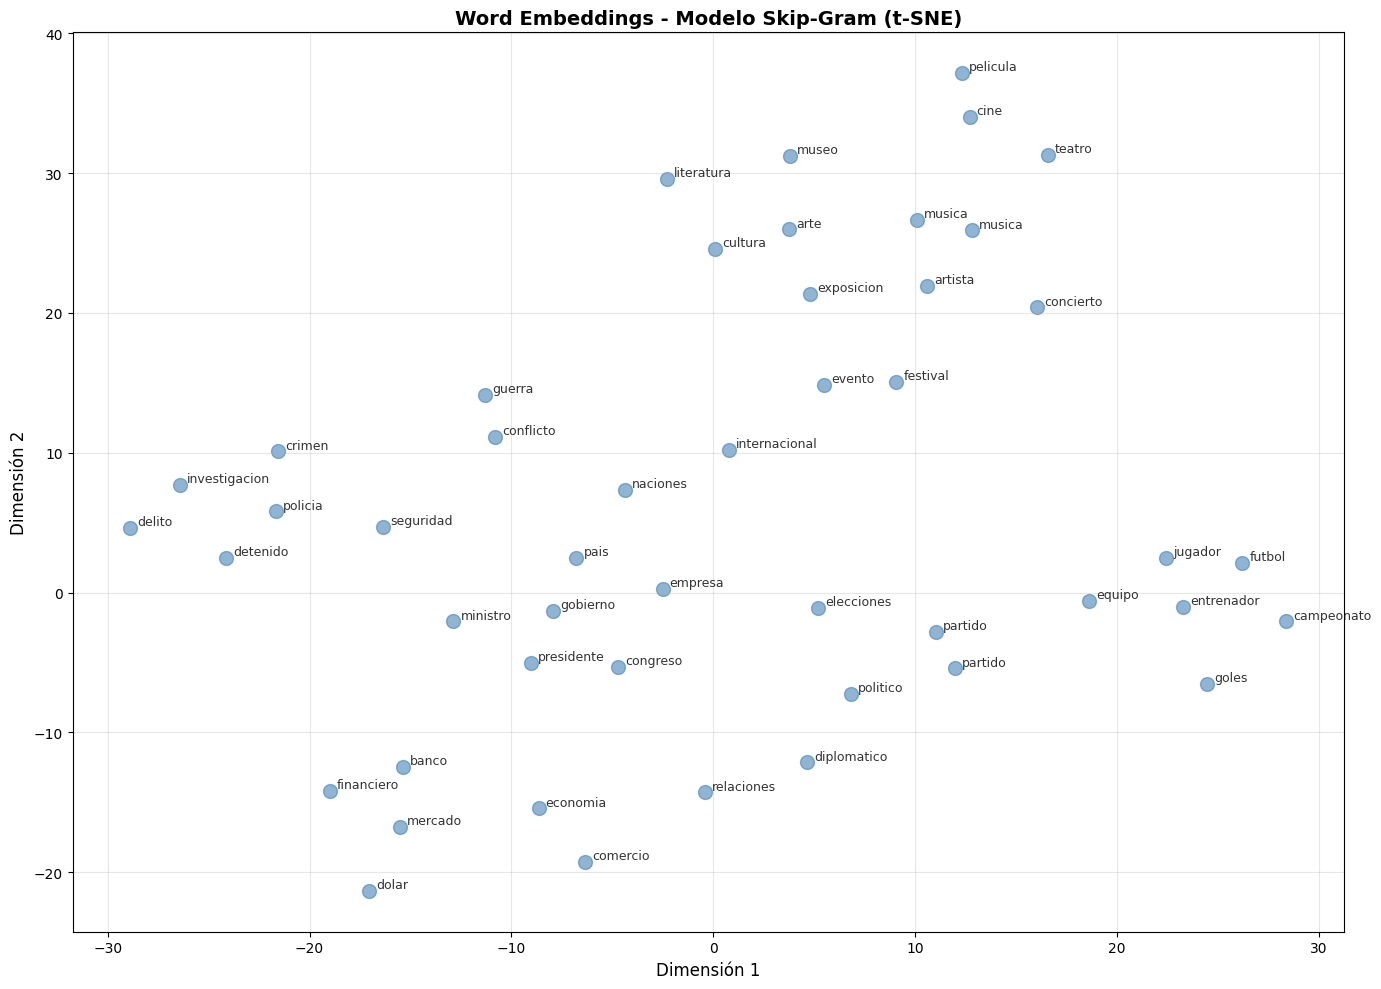

In [32]:
visualize_embeddings_tsne(
    model_skipgram, 
    todas_palabras, 
    title="Word Embeddings - Modelo Skip-Gram (t-SNE)",
    perplexity=10
)

In [33]:
def visualize_embeddings_pca(model, words, title="Word Embeddings (PCA)"):
    valid_words = [w for w in words if w in model.wv]

    vectors = np.array([model.wv[w] for w in valid_words])

    pca = PCA(n_components=2, random_state=42)
    vectors_2d = pca.fit_transform(vectors)


    plt.figure(figsize=(14, 10))
    plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], alpha=0.6, s=100, color='coral')

    for i, word in enumerate(valid_words):
        plt.annotate(word, xy=(vectors_2d[i, 0], vectors_2d[i, 1]),
                    xytext=(5, 2), textcoords='offset points',
                    fontsize=9, alpha=0.8)
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

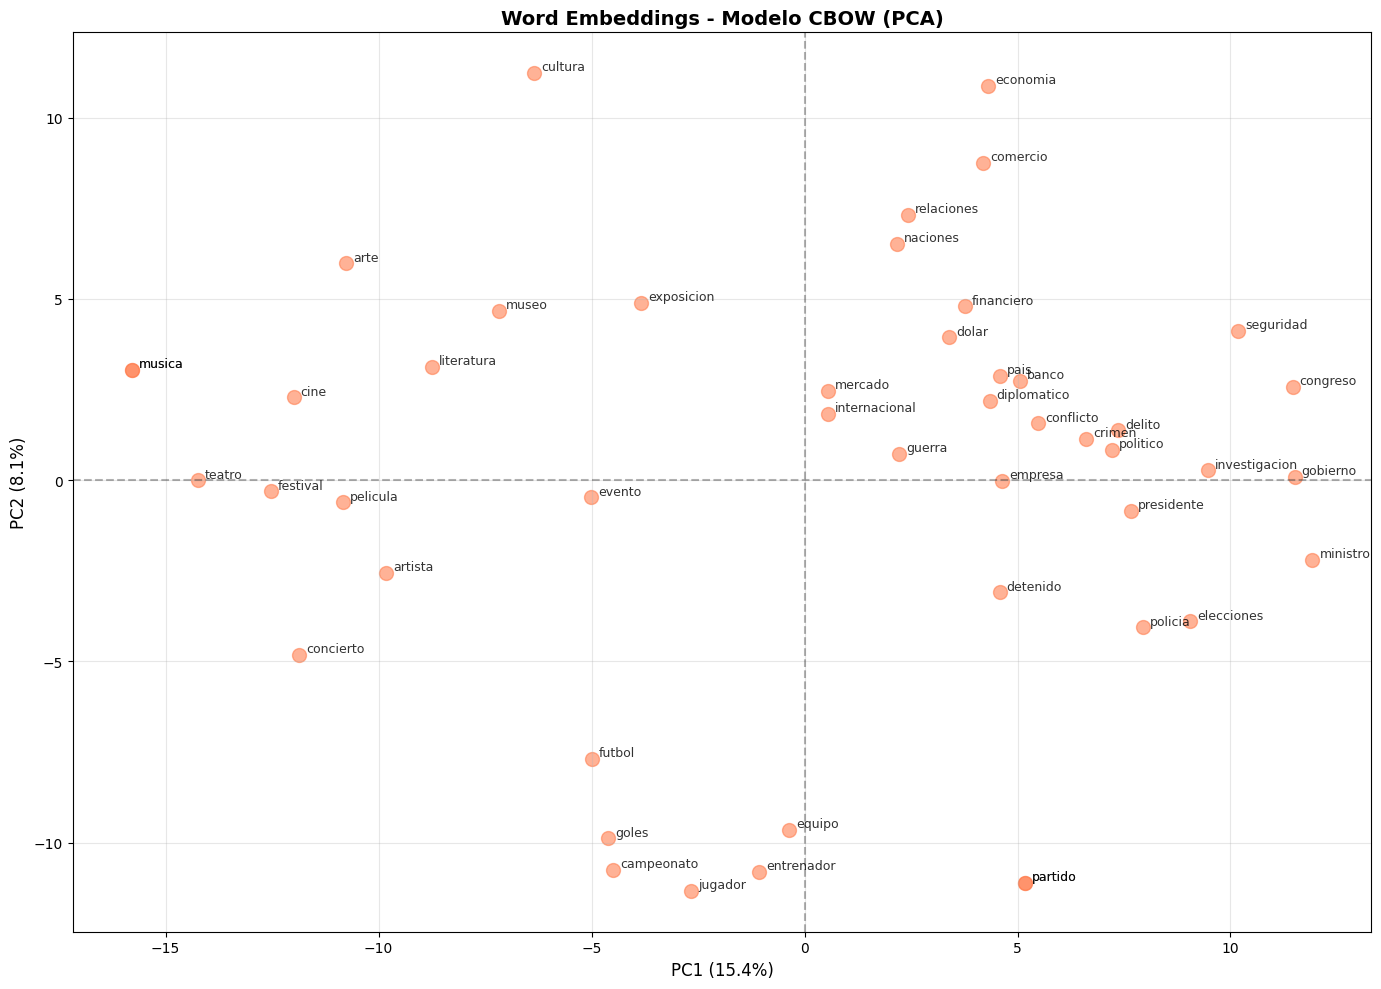

In [34]:
visualize_embeddings_pca(
    model_cbow, 
    todas_palabras, 
    title="Word Embeddings - Modelo CBOW (PCA)"
)

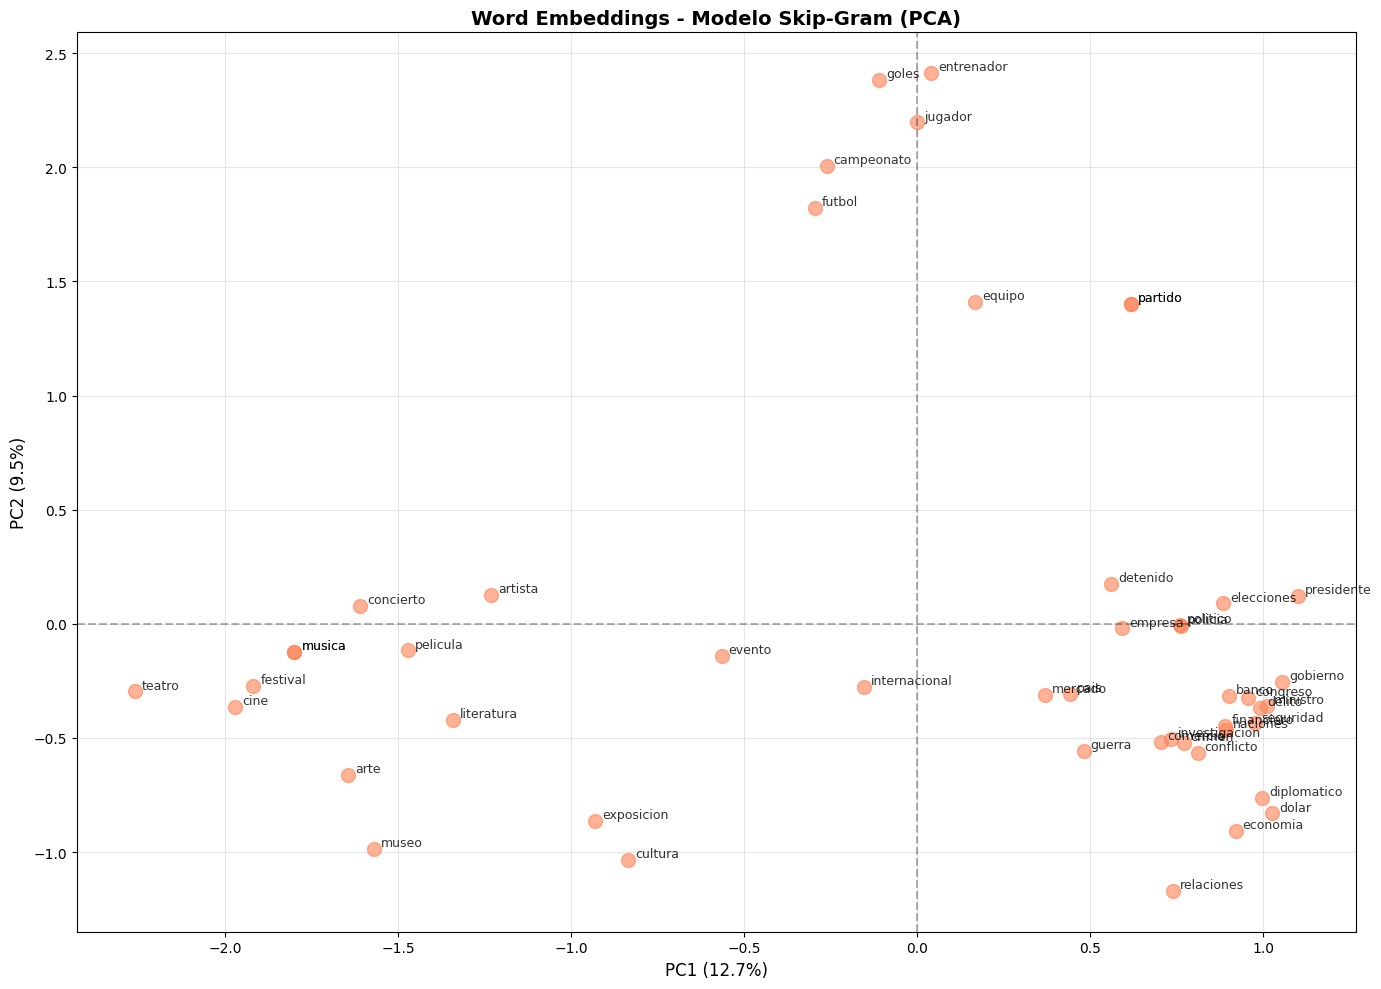

In [35]:
visualize_embeddings_pca(
    model_skipgram, 
    todas_palabras, 
    title="Word Embeddings - Modelo Skip-Gram (PCA)"
)

### Visualización de Documentos por Tópico

In [36]:
def get_document_embedding(model, tokens):

    vectors = []
    for token in tokens:
        if token in model.wv:
            vectors.append(model.wv[token])
    
    if len(vectors) == 0:
        return None
    
    return np.mean(vectors, axis=0)

categories = ["Deportes", "Política", "Economía", "Mundo", "Espectáculos", "Policiales", "Cultura"]
sample_docs = []
sample_labels = []

for cat in categories:
    docs_cat = df[df['seccion'] == cat].head(10)
    for idx in docs_cat.index:
        tokens = sentences[idx]
        emb = get_document_embedding(model_cbow, tokens)
        if emb is not None:
            sample_docs.append(emb)
            sample_labels.append(cat)

sample_docs = np.array(sample_docs)

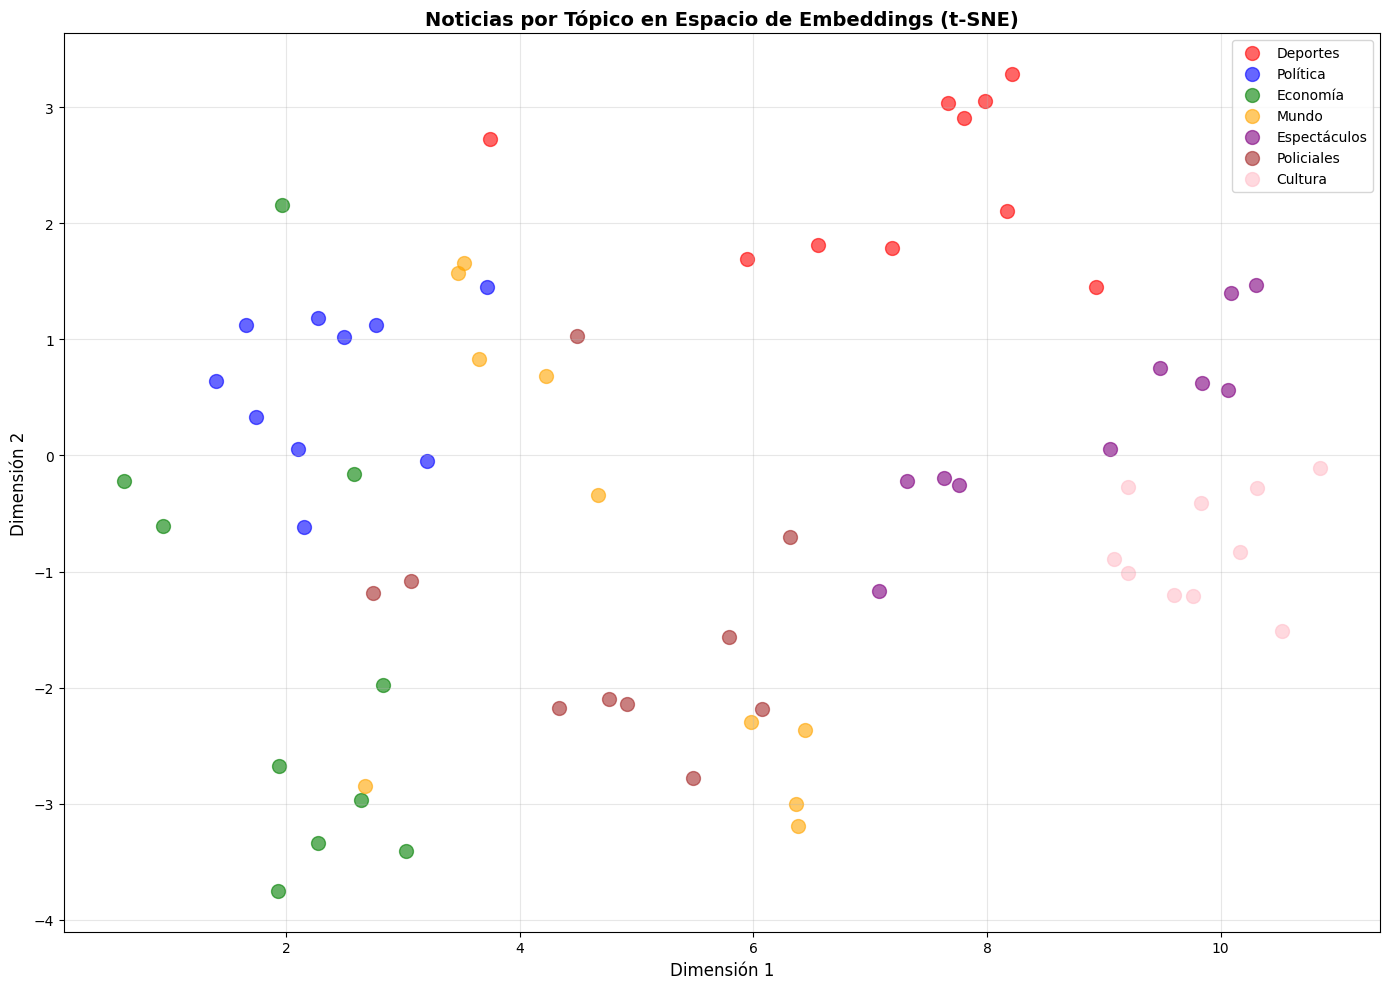

In [37]:

tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(sample_docs)-1))
docs_2d = tsne.fit_transform(sample_docs)

plt.figure(figsize=(14, 10))

colors = {'Deportes': 'red', 'Política': 'blue', 'Economía': 'green', 
          'Mundo': 'orange', 'Espectáculos': 'purple', 'Policiales': 'brown', 'Cultura': 'pink'}

for cat in categories:
    indices = [i for i, label in enumerate(sample_labels) if label == cat]
    if indices:
        plt.scatter(
            docs_2d[indices, 0], 
            docs_2d[indices, 1],
            c=colors.get(cat, 'gray'),
            label=cat,
            alpha=0.6,
            s=100
        )

plt.title('Noticias por Tópico en Espacio de Embeddings (t-SNE)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Dimensión 1', fontsize=12)
plt.ylabel('Dimensión 2', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



Varianza explicada:
  PC1: 27.90%
  PC2: 12.22%
  Total: 40.12%


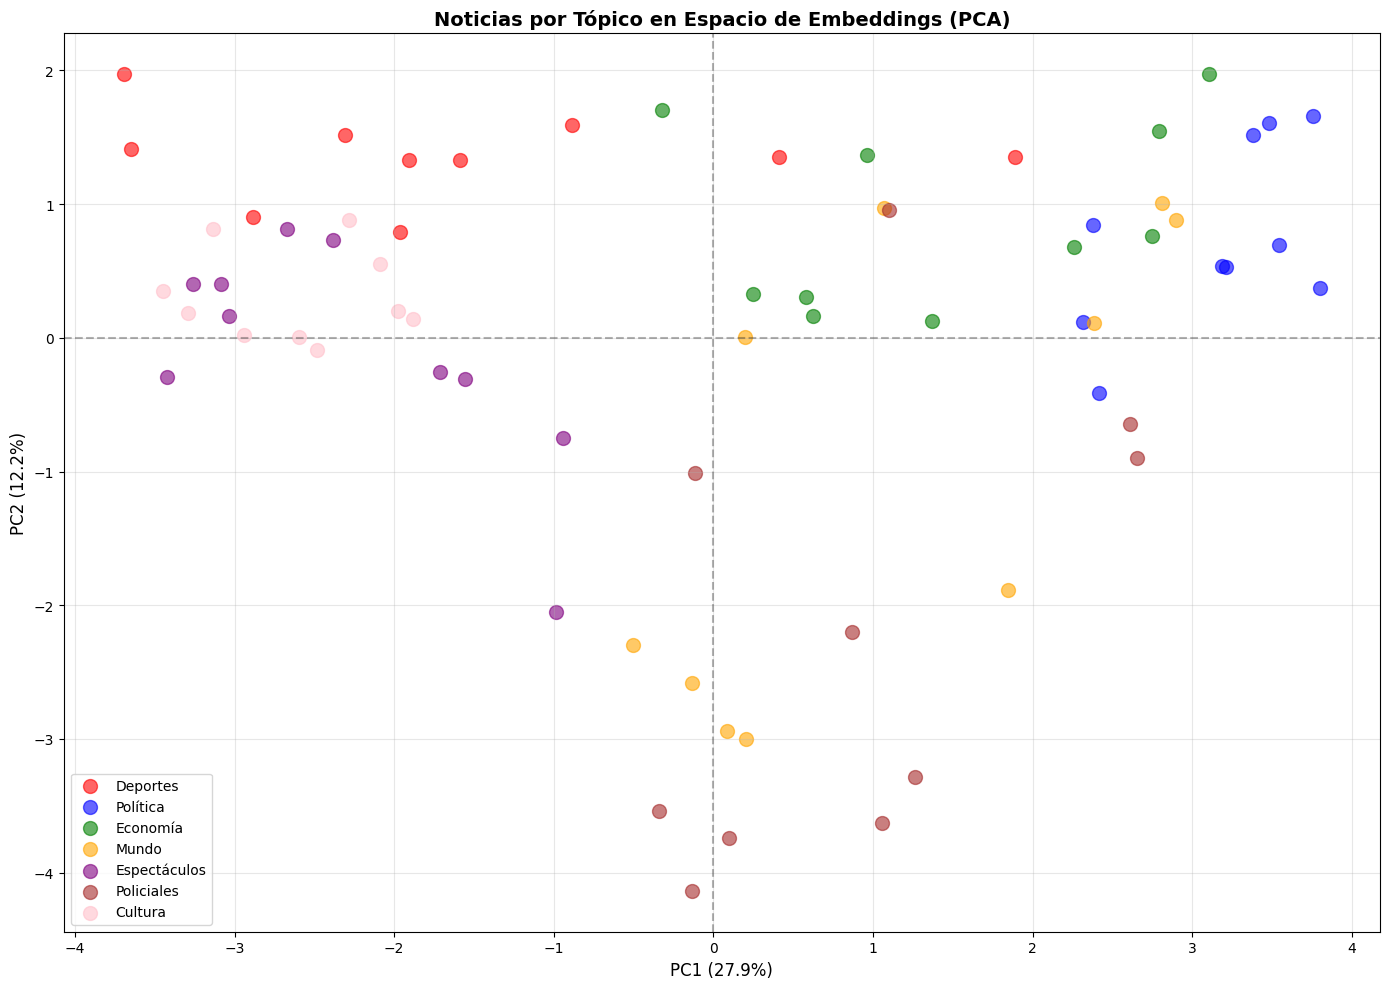

In [38]:

pca = PCA(n_components=2, random_state=42)
docs_2d_pca = pca.fit_transform(sample_docs)

print(f"\nVarianza explicada:")
print(f"  PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"  PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"  Total: {sum(pca.explained_variance_ratio_)*100:.2f}%")

plt.figure(figsize=(14, 10))

for cat in categories:
    indices = [i for i, label in enumerate(sample_labels) if label == cat]
    if indices:
        plt.scatter(
            docs_2d_pca[indices, 0], 
            docs_2d_pca[indices, 1],
            c=colors.get(cat, 'gray'),
            label=cat,
            alpha=0.6,
            s=100
        )

plt.title('Noticias por Tópico en Espacio de Embeddings (PCA)', 
          fontsize=14, fontweight='bold')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [39]:
# Guardar modelos (opcional)
model_cbow.save("word2vec_cbow_noticias.model")
model_skipgram.save("word2vec_skipgram_noticias.model")

print("Modelos guardados")

Modelos guardados
